# Dynamic Mapping

In many cases, data for creating maps are retrievable in regular intervals or available historically. In such cases, 
dynamic mapping can uncover additional insights beyond what static maps can offer.  

Dynamic mapping, however, is more challenging than simply creating a (static) map at each point in time (see [[1]](#ref_1)).
The dynamic mapping framework *EvoMap* provides one solution to this problem. *EvoMap* integrates various static mapping methods 
and allows the analyst to use them for creating dynamic market maps. Thereby, it provides the analyst with a high degree of control 
over its output (e.g., by letting the analyst set certain constraints on the resultant maps, such as the degree of smoothing). 

For methodological background and a detailed description, see the original paper [[1]](#ref_1).

This tutorial demonstrates how to use *EvoMap* to create dynamic market maps from time-evolving relationship data. The tutorial covers data preparation, running the method, evaluating its results, tuning its hyperparameter and several useful functions provided as part of this package (e.g., for drawing dynamic market maps).  

## Sections

1. [Data Preparation](#section_1)

2. [Running the Method](#section_2)

3. [Output Exploration](#section_3)

4. [Quantitative Evaluation](#section_4)

5. [Hyperparameter Tuning](#section_5)

6. [Chosing Different Mapping Methods](#section_6)

7. [Special Cases and Extensions](#section_7)

## Background

**Last updated:** September 2022

This tutorial is based on the following paper. *If you use this package or parts of its code, please cite our work*.

**References**

<a name = "ref_1"></a>
``` 
[1]Matthe, M., Ringel, D. M., Skiera, B. (2022), "Mapping Market Structure Evolution", Marketing Science, forthcoming.
```

Read the **full paper** here (open access): <a href = 'https://doi.org/10.1287/mksc.2022.1385'>https://doi.org/10.1287/mksc.2022.1385</a>

**Contact:** In case of questions, problems or for feedback, please <a href = 'mailto:matthe@wiwi.uni-frankfurt.de'>get in touch</a>.

## Data Preparation
<a id = 'section_1'></a>
First, load all required imports for this tutorial and set the seed to ensure reproducibility. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(123) 

For this tutorial, we use a subsample of the 'Text-Based Network Industry Classification' data also used in [[1]](#ref_1). The original data is provided at https://hobergphillips.tuck.dartmouth.edu/. The data consists of a time-indexed edgelist, that is, firm-firm relationships. 

For more background on TNIC data, see:

<a name = "ref_2"></a> 
```
[2] Hoberg, G & Phillips, G. (2016), "Text-Based Network Industries and Endogenous Product Differentiation.", Journal of Political Economy 124 (5), 1423-1465.
```

If you intend to use these data, make sure to cite these authors' original work!

We augment the TNIC edgelist with further firm information. Moreover, we limit our analysis to a subsample of firms (i.e., those which are present throughout the whole observation period of 20 years). Our augmented data includes the following variables: 

| Variable | Description | Type |
| --- | --- | --- |
| year | Fiscal year | int |
| gvkey | Firm identifier | int |
| score | Similarity score | float |
| name | Firm name | string |
| size | Firm size (synthetic variable, correlated with market capitalization) | float |
| sic | SIC Code | string |

In the resultant dataset, each row corresponds to a single firm-firm pair at a specific point in time. Thus, each firm variable appears twice in each row (once for each firm). We provide this dataset in the `datasets` module.

In [2]:
from evomap.datasets import load_tnic_sample_small
df_sample = load_tnic_sample_small()
df_sample.head()

,year,gvkey1,gvkey2,score,name1,name2,sic1,sic2,size1,size2
0,1998,1078,1602,0.0274,ABBOTT LABORATORIES,AMGEN INC,3845,2836,74.211937,36.866437
1,1999,1078,1602,0.0352,ABBOTT LABORATORIES,AMGEN INC,3845,2836,87.854384,48.541222
2,2000,1078,1602,0.0348,ABBOTT LABORATORIES,AMGEN INC,3845,2836,70.098508,93.428689
3,2001,1078,1602,0.0218,ABBOTT LABORATORIES,AMGEN INC,3845,2836,110.299430,34.410965
4,2002,1078,1602,0.0366,ABBOTT LABORATORIES,AMGEN INC,3845,2836,40.140853,42.840198


The original sample includes more than 1,000 different firms. To simplify our demonstration (and accelerate the runtime of this notebook), we pick a smaller subsample from these data focused on the biggest firms (by market value) and their competitors.

In [3]:
print("The subsample includes {0} firms and {1} years".format(df_sample.name1.nunique(), df_sample.year.nunique()))

The subsample includes 273 firms and 20 years


We need to turn this edgelist into a sequence of relationship matrices. Specifically, the expected input for *EvoMap* is a list of numpy ndarrays, each containing the pairwise relationships among all firms at a specific point in time. 

**Important:** Make sure that each matrix has the same size and that its rows & columns are ordered consistently! If you do not observe certain firms at some points in time (e.g., due to entry or exit), you should provide inclusion vectors (covered [later](#inclusions)).

`evomap.preprocessing` provides helpful functions for the required transformations: 

In [4]:
from evomap.preprocessing import edgelist2matrix, sim2diss

def build_distance_matrices(df):
    """Build a sequence of distance matrices from the tnic edgelist.

    As the tnic data consists of pairwise similarities, we apply the 'sim2diss' 
    function to each similarity matrix to yield distance matrices.

    Parameters
    ----------
    df : pd.DataFrame
        Tnic data in edgelist format. 

    Returns
    -------
    Ds, names, years
        Ds: list of distance matrices, each as a numpy ndarray
        names: array of firm labels
        years: array o year labels
    """
    years = df['year'].sort_values().unique()
    Ds = []
    for year in years:
        S_t, names = edgelist2matrix(
            df = df,
            score_var = 'score',
            id_var_i = 'name1',
            id_var_j = 'name2',
            time_var = 'year',
            time_selected = year)
        D_t = sim2diss(S_t, transformation = 'inverse')
        Ds.append(D_t)
                
    return Ds, names, years

Ds, names, years = build_distance_matrices(df_sample)
n_samples = Ds[0].shape[0]
n_periods = len(Ds)

## Running EvoMap
<a id = 'section_2'></a>

EvoMap is part of the `evomap.mapping` module. 

Before we run the method, we first fix a random starting initialization. While you do not need to provide a starting initialization explicitly, doing so is helpful when comparing the derived maps to solutions by other approaches. 

In [5]:
Y_init = np.random.normal(0.0,1.0,size=(n_samples,2))
Y_inits = [Y_init]*n_periods

Then, choose a value for the hyperparamter alpha, initialize the model accordingly, and fit it to the data. We will cover ways how to identify appropriate values for EvoMap's hyperparameters [later](#section_5)

In [6]:
from evomap.mapping.evomap import EvoTSNE
model = EvoTSNE(
    verbose = 2,
    alpha = 0.001,
    p = 1)

Ys = model.fit_transform(Ds)

[EvoTSNE] Initialization 1/1
[EvoTSNE] Gradient descent with Momentum: 0.5
[EvoTSNE] Iteration 50 -- Cost: 245.10 -- Gradient Norm: 0.1721
[EvoTSNE] Iteration 100 -- Cost: 239.81 -- Gradient Norm: 0.0978
[EvoTSNE] Iteration 150 -- Cost: 237.70 -- Gradient Norm: 0.1199
[EvoTSNE] Iteration 200 -- Cost: 235.00 -- Gradient Norm: 0.0824
[EvoTSNE] Iteration 250 -- Cost: 233.33 -- Gradient Norm: 0.0747
[EvoTSNE] Maximum number of iterations reached. Final cost: 233.33
[EvoTSNE] Gradient descent with Momentum: 0.8
[EvoTSNE] Iteration 300 -- Cost: 18.78 -- Gradient Norm: 0.0143
[EvoTSNE] Iteration 350 -- Cost: 17.20 -- Gradient Norm: 0.0036
[EvoTSNE] Iteration 400 -- Cost: 17.08 -- Gradient Norm: 0.0017
[EvoTSNE] Iteration 450 -- Cost: 16.97 -- Gradient Norm: 0.0037
[EvoTSNE] Iteration 500 -- Cost: 16.80 -- Gradient Norm: 0.0041
[EvoTSNE] Iteration 536: gradient norm vanished.


The output is a list of map coordinates, each stored in a ndarray of shape (n_samples, d), where d is typically = 2. 

This package provides multiple tools to explore these results. Here, we look at the first 4 maps as a sequence. We cover more advanced alternatives for exploration in [Section 3: Exploring Model Output](#section_3).

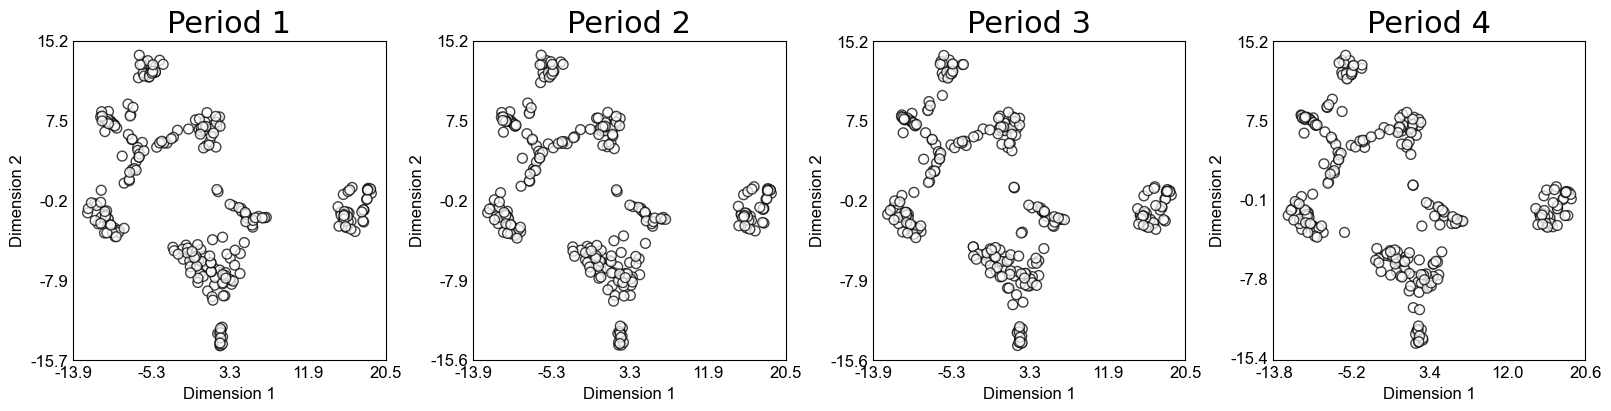

In [7]:
from evomap.printer import draw_map_sequence
draw_map_sequence(Ys[:4])

<a id = 'section_3'></a>
## Exploring Model Output

This package provides three ways to explore EvoMap's output: 

1. [Draw a static map](#static_map)
2. [Draw a sequence of static maps](#sequence)
3. [Draw a dynamic map](#dynamic_map) (i.e., an overlay of subsequent maps)

All necessary functions are included in the "printer" module and provide lots of flexibility to adjust their aesthetics.

<a id = 'static_map'></a>
### Draw a Static Map

To draw a single static map, simply use the corresponding function ```draw_map()```.

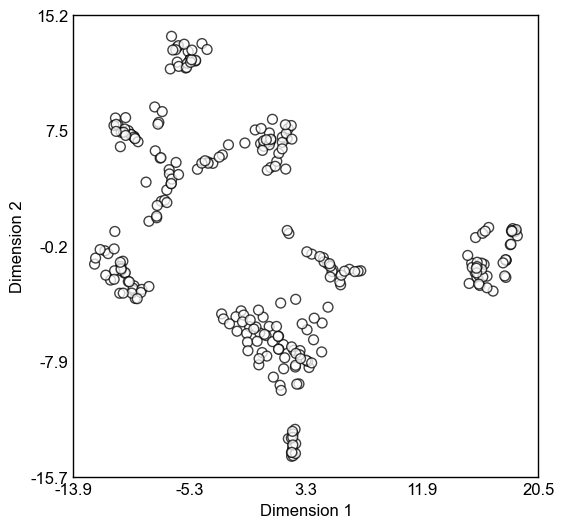

In [8]:
from evomap.printer import draw_map

draw_map(Ys[0])

Aesthetics of the map can easily be adjusted via additional arguments. For instance, if class labels are available (e.g., obtained via clustering or additional metadata), they can be added as colors. Here, we can use SIC codes for coloring:

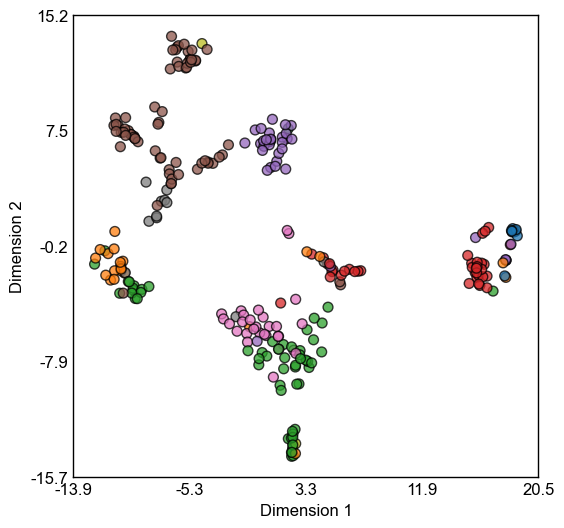

In [9]:
sic_codes = pd.DataFrame({'name1' : names}).merge(df_sample[['name1', 'sic1']], on = 'name1', how = 'left').drop_duplicates('name1')['sic1'].map(lambda x: str(x)[:1]).values
draw_map(Ys[0], color = sic_codes)

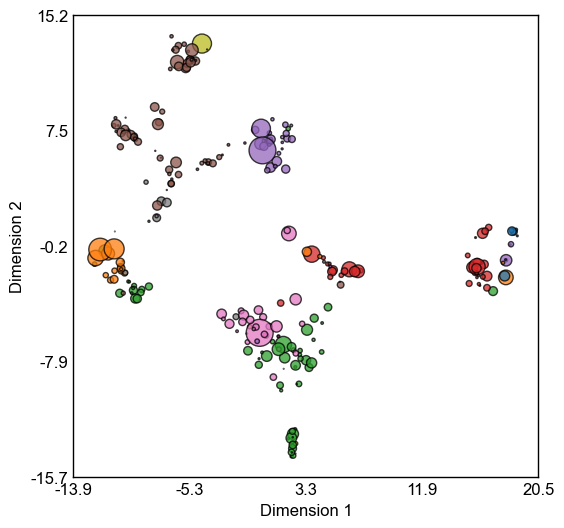

In [10]:
sizes = pd.DataFrame({'name1' : names}).merge(df_sample[['name1', 'size1']], on = 'name1', how = 'left').drop_duplicates('name1')['size1'].values
draw_map(Ys[0], color = sic_codes, size = sizes)

One can also annotate the map further using labels. Note that you can also use additional keyword arguments to adjust the plot and its labels further. 

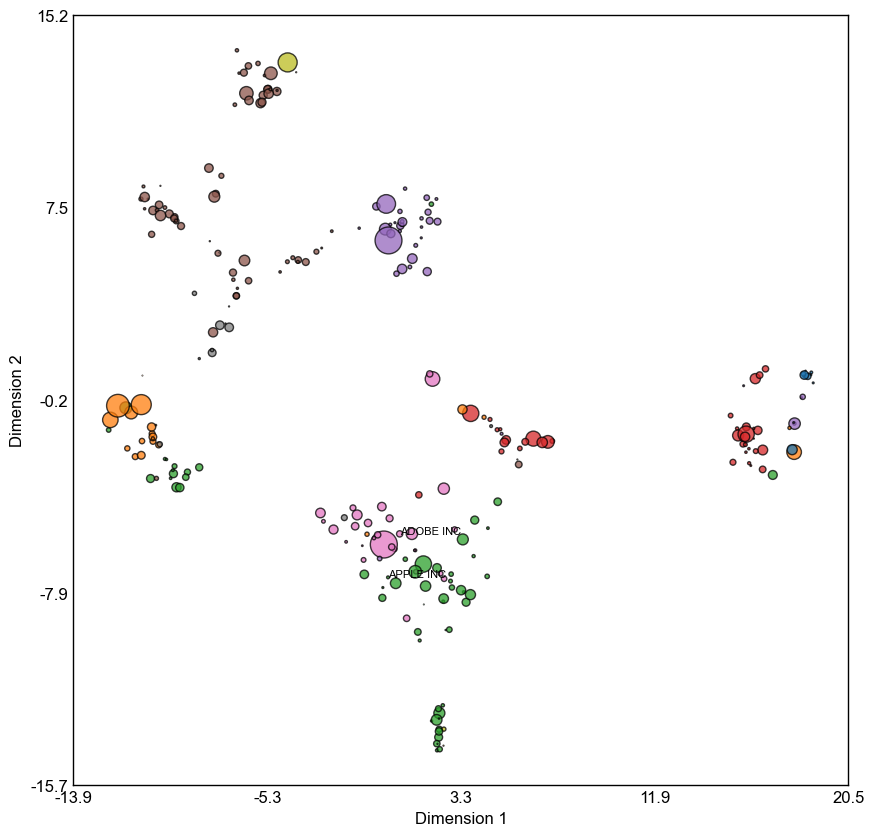

In [11]:
draw_map(
    Ys[0], 
    color = sic_codes, 
    size = sizes,
    label = names, 
    highlighted_labels = ['APPLE INC', 'ADOBE INC'],
    fig_size = (10,10),
    fontdict = {'size': 8},
    scatter_kws = {'edgecolor' : 'black'})

<a id = 'sequence'></a>
### Draw a Sequence of Maps

Rather than drawing a single map, you can also draw a sequence via ```draw_map_sequence()```.

The function takes a list of ndarrays (each containing the map coordinates for one period) and creates a map for each of them:

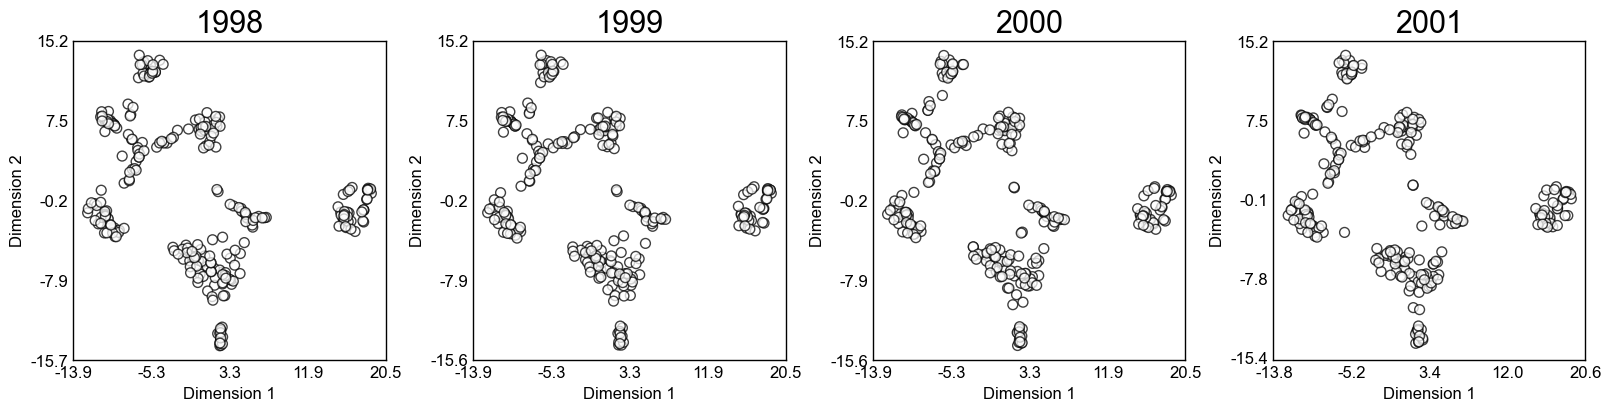

In [12]:
from evomap.printer import draw_map_sequence
draw_map_sequence(Ys[:4], n_cols = 4, time_labels = years, show_axes = True)

Map aesthetics can be adjusted analogously to drawing a static map. To do so, simply provide arguments of ```draw_map()``` as keyword arguments to ```draw_map_sequence()```:

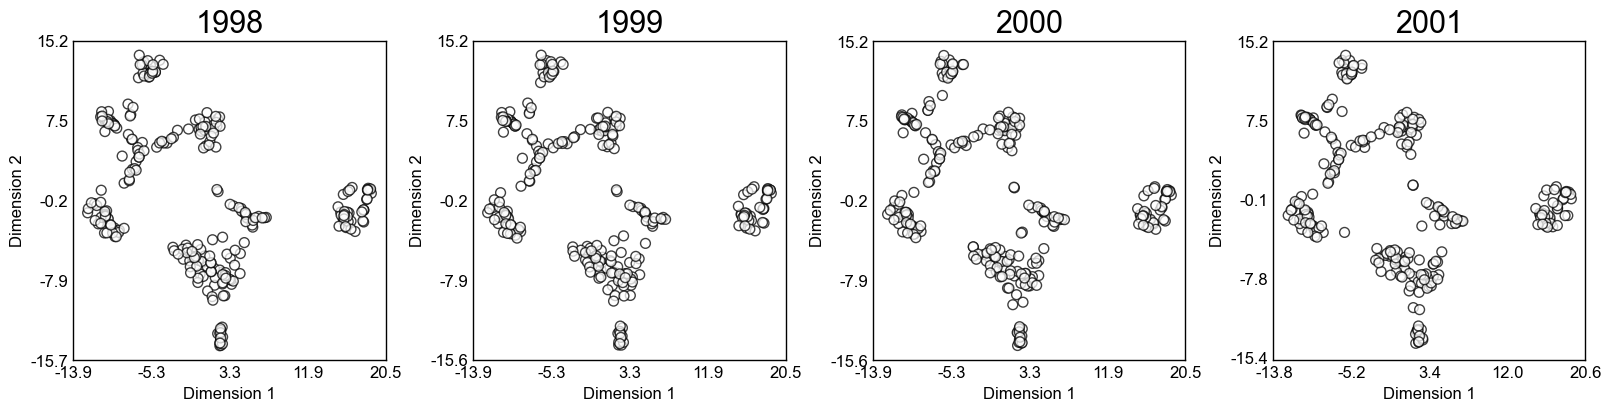

In [13]:
draw_map_sequence(Ys[:4], time_labels = years, 
                  c = sic_codes, labels = names, highlight_labels = ['APPLE INC', 'INTUIT INC'])

<a id = 'dynamic_map'></a>
### Draw a Dynamic Map

The third option - and often the most interesting one - is to explore all periods jointly via a *dynamic map* (i.e., an overlay of multiple subsequent maps). To do so, use ```draw_dynamic_map()``` as follows:

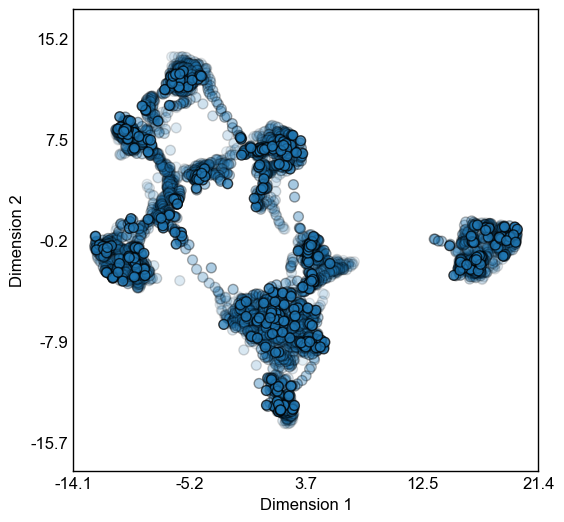

In [14]:
from evomap.printer import draw_dynamic_map
draw_dynamic_map(Ys)

```draw_dynamic_map()``` also provides some options to reveal the individual trajectories of each firm. 

Thereby, all arguments for ```draw_map()``` can also be passed to ```draw_dynamic_map()``` as keyword arguments to control the resultant map's aesthetics. Naturally, the arguments of both functions can also be combined arbitrarily (for instance, highlighting labels for same objects, while highlighting the trajectories of others): 

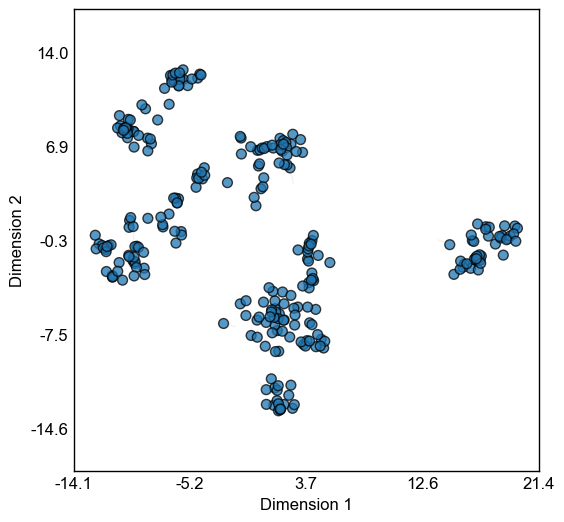

In [15]:
draw_dynamic_map(Ys, show_arrows = True, show_last_positions_only=True)

Besides drawing the full map, you can also focus on individual firms and their trajectories. To do so, the dedicated function 

```draw_trajectories()``` 

is available. 

Besides map coordinates and labels (e.g., firm names), this function expects you to provide a list (or array) of focus firms, for which the trajectories should be displayed:

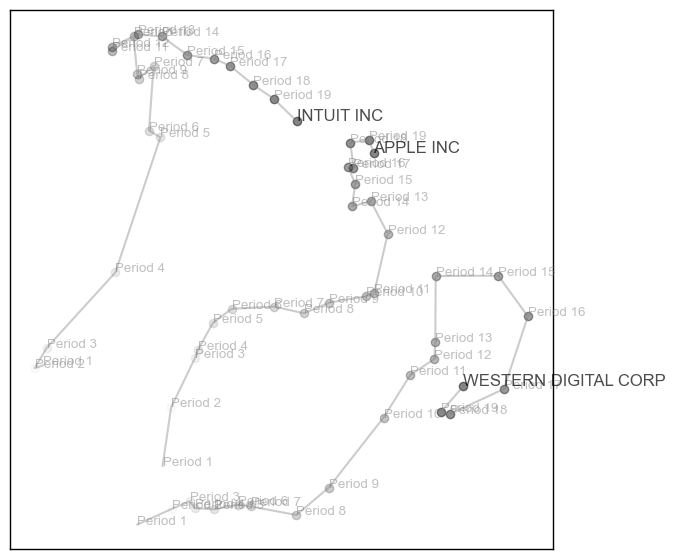

In [16]:
from evomap.printer import draw_trajectories
focus_firms = [
    'INTUIT INC',
    'WESTERN DIGITAL CORP', 
    'APPLE INC']    
draw_trajectories(Ys, labels = names, selected_labels = focus_firms)

To ease interpretation, you can add annotations for all periods:

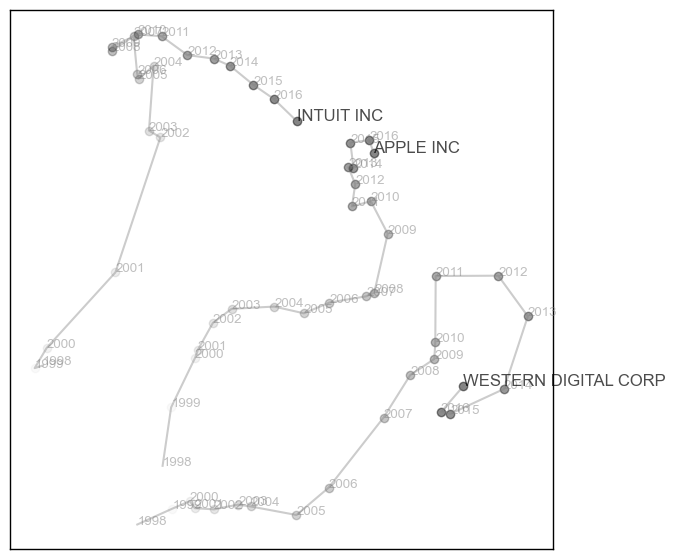

In [17]:
draw_trajectories(Ys, labels = names, selected_labels = focus_firms, period_labels = years)

<a id = 'section_4'></a>
## Evaluating Model Output

How "good" are these maps (e.g., how well do they fit the input data? How well do they reveal underyling changes?)? 

To answer this question, the following metrics are available. All functions are located within the 'metrics' module. For more background on these metrics, see [[1]](#ref_1).


| Metric | Description | Function | Computed for | 
| --- | --- | --- | --- |
| Hitrate | Nearest neighbor recovery (in %) | ```hitrate_score()``` | Single Map| 
| Adjusted Hitrate | Hitrate, adjusted for random agreement | ```adjusted_hitrate_score()``` | Single Map |
| Avg. Hitrate | Avgerage Hitrate | ```avg_adjusted_hitrate_score()``` | Sequence of Maps |
| Avg. Adjusted Hitrate | Adjusted Hitrate, averaged across subsequent maps | ```avg_adjusted_hitrate_score()``` | Sequence of Maps |
| Misalignment | Average Distance of subsequent map positions  | ```misalign_score()```  | Sequence of Maps |
| Alignment | Cosine similarity of subsequent map positions | ```align_score()``` | Sequence of Maps |
| Persistence | Autocorrelation coeff. of first differences <br> of objects' subsequent map positions | ```persistence_score()``` | Sequence of Maps |



In [18]:
from evomap.metrics import avg_hitrate_score, misalign_score, persistence_score

In [19]:
df_eval = pd.DataFrame({
    'Avg Hitrate': avg_hitrate_score(Ys,Ds, input_format = 'dissimilarity'),
    'Misalignment': misalign_score(Ys),
    'Persistence': persistence_score(Ys)
}, index = ['EvoMap'])

df_eval

,Avg Hitrate,Misalignment,Persistence
EvoMap,0.645403,0.015256,0.522881


To benchmark these values, we apply t-SNE independently to each distance matrix.

`evomap.mapping` also includes the respective static variant for each method:

In [20]:
from evomap.mapping import TSNE
Ys_indep = []
for t in range(len(Ds)):
    Ys_t = TSNE().fit_transform(Ds[t])
    Ys_indep.append(Ys_t)

In [21]:
df_eval = pd.concat((df_eval, pd.DataFrame({
    'Avg Hitrate': avg_hitrate_score(Ys_indep, Ds, input_format = 'dissimilarity'),
    'Misalignment': misalign_score(Ys_indep),
    'Persistence': persistence_score(Ys_indep)
}, index = ['Indep. TSNE'])), axis = 0)
df_eval

,Avg Hitrate,Misalignment,Persistence
EvoMap,0.645403,0.015256,0.522881
Indep. TSNE,0.660128,1.014649,-0.593228


<AxesSubplot:>

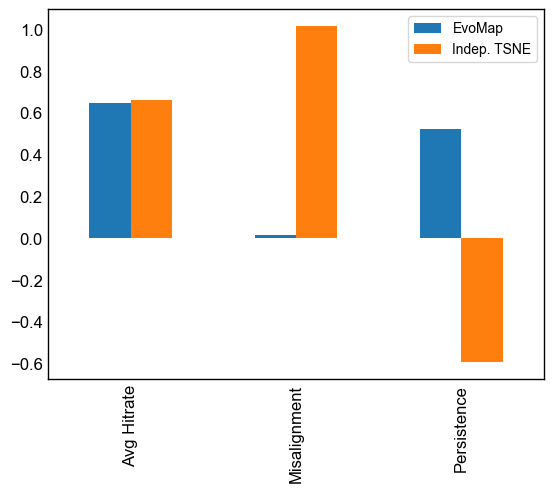

In [22]:
df_eval.T.plot(kind = 'bar')

<a id = 'section_5'></a>
## Hyperparameter Selection: 

The metrics introduced in the last section are well suited to tune EvoMap's hyperparameters. 

Specifically, there are two hyperparameters one needs to set when applying EvoMap: 

- alpha (float): Controls the degree of alignment 
- p (int): Controls the degree of smoothing

'Good' values for these parameters naturally depend on the given input data. Therefore, one should always test multiple values for them and compare their results visually and quantitatively (e.g., via visual inspection together with the metrics introduced in the previous section). 

To make such comparisons as easy as possible, EvoMap features a  ```grid_search()``` function. Given some input data and a grid of parameter values, this function creates a map sequence for each parameter combination and summarizes the results. 

First, define the parameter grid as a Python dictionary. We use a rather narrow one here for demonstration purpose (and to speed up runtime). We recommend, however, to always start with a broad range and narrow it down later. 

In [23]:
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001], 
    'p': [1,2]}

Next, define which metrics should be used to evaluate each combination from the grid:

In [24]:
metrics = [misalign_score, persistence_score, avg_hitrate_score]
metric_labels = ['Misalignment', 'Persistence', 'Hitrate']

Then, initialize the model and start the grid search (available for each implementation of EvoMap):

In [25]:
model = EvoTSNE(verbose = 2, init = Y_inits)

df_grid_results = model.grid_search(
    Xs = Ds, 
    param_grid = param_grid, 
    eval_functions =  metrics,
    eval_labels = metric_labels, 
    kwargs = {'input_format' : 'dissimilarity'})

[EvoTSNE] Evaluating parameter grid..
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-05, 'p': 1}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 1e-05, 'p': 2}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 0.0001, 'p': 1}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 0.0001, 'p': 2}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 0.001, 'p': 1}
[EvoTSNE] .. evaluating parameter combination: {'alpha': 0.001, 'p': 2}
[EvoTSNE] Grid Search Completed.


In [26]:
df_grid_results

,p,cost_static_avg,Misalignment,Persistence,Hitrate
alpha,,,,,
0.00001,1,0.797360,0.078530,-0.189828,0.658260
0.00001,2,0.799216,0.062083,0.009897,0.656813
0.00010,1,0.804662,0.038965,0.077161,0.656136
0.00010,2,0.814454,0.030329,0.525006,0.650861
0.00100,1,0.826555,0.015048,0.535425,0.644011
0.00100,2,0.833138,0.011928,0.822131,0.640641


<AxesSubplot:xlabel='alpha', ylabel='Persistence'>

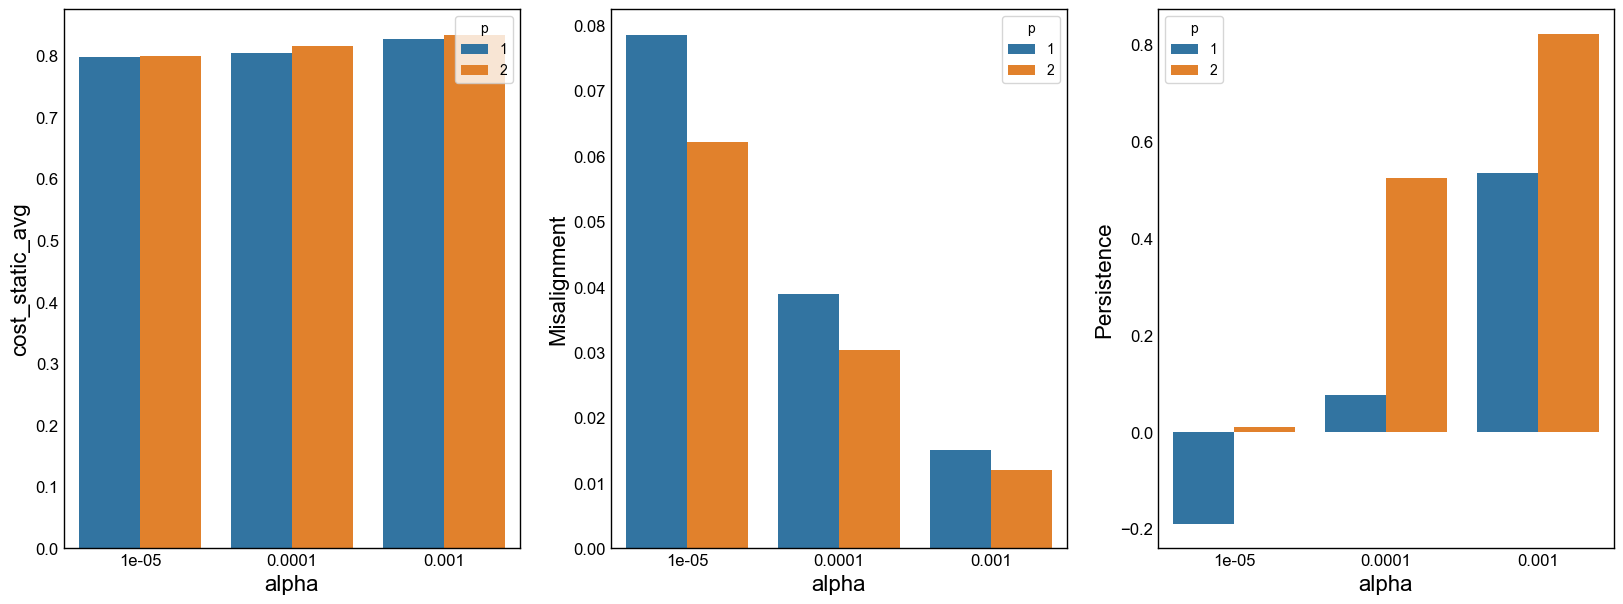

In [27]:
fig, ax = plt.subplots(1,3, figsize = (20,7))

sns.barplot(x = 'alpha', y = 'cost_static_avg', hue = 'p', data = df_grid_results.reset_index(), ax = ax[0])
sns.barplot(x = 'alpha', y = 'Misalignment', hue = 'p', data = df_grid_results.reset_index(), ax = ax[1])
sns.barplot(x = 'alpha', y = 'Persistence', hue = 'p', data = df_grid_results.reset_index(), ax = ax[2])

Based on this evaluation, you can select suitable parameter combinations and inspect them further visually. 

Here, alpha = 0.001 and p = 2 seem reasonable, as this combination decreases misalignment, increases persistence, but does not increase static cost substantially. To use them, either create a new model instance or use the ```set_params()``` function to override the parameters of an existing model instance.

In [28]:
Y_t = model.set_params({'alpha': 0.001, 'p': 2}).fit_transform(Ds)

[EvoTSNE] Initialization 1/1
[EvoTSNE] Gradient descent with Momentum: 0.5
[EvoTSNE] Iteration 50 -- Cost: 234.25 -- Gradient Norm: 0.2282
[EvoTSNE] Iteration 100 -- Cost: 229.56 -- Gradient Norm: 0.1524
[EvoTSNE] Iteration 150 -- Cost: 228.39 -- Gradient Norm: 0.1317
[EvoTSNE] Iteration 200 -- Cost: 227.98 -- Gradient Norm: 0.0922
[EvoTSNE] Iteration 250 -- Cost: 227.71 -- Gradient Norm: 0.0523
[EvoTSNE] Maximum number of iterations reached. Final cost: 227.71
[EvoTSNE] Gradient descent with Momentum: 0.8
[EvoTSNE] Iteration 300 -- Cost: 17.64 -- Gradient Norm: 0.0509
[EvoTSNE] Iteration 350 -- Cost: 17.27 -- Gradient Norm: 0.0099
[EvoTSNE] Iteration 400 -- Cost: 17.14 -- Gradient Norm: 0.0069
[EvoTSNE] Iteration 450 -- Cost: 17.09 -- Gradient Norm: 0.0059
[EvoTSNE] Iteration 500 -- Cost: 17.06 -- Gradient Norm: 0.0033
[EvoTSNE] Iteration 550 -- Cost: 17.04 -- Gradient Norm: 0.0029
[EvoTSNE] Iteration 600 -- Cost: 17.03 -- Gradient Norm: 0.0024
[EvoTSNE] Iteration 650 -- Cost: 17.01 -

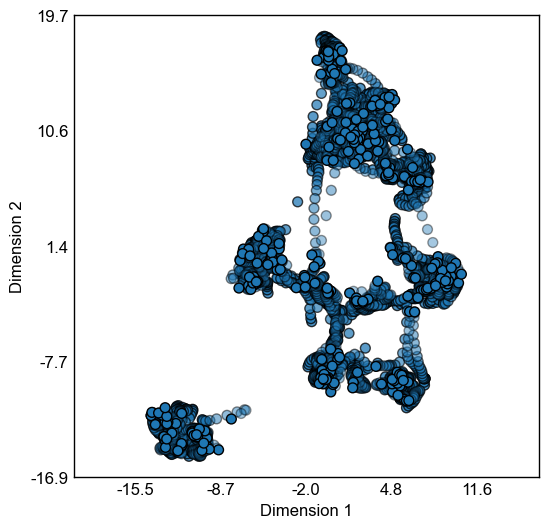

In [29]:
draw_dynamic_map(Y_t, color = sic_codes, transparency_start= .8, transparency_final=1)

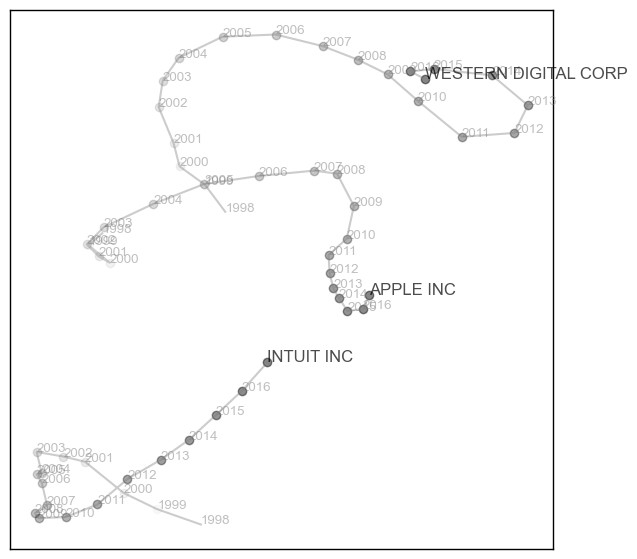

In [30]:
focus_firms = [
    'INTUIT INC',
    'WESTERN DIGITAL CORP', 
    'APPLE INC']

draw_trajectories(Y_t, labels = names, selected_labels = focus_firms, period_labels = years)

As with any unsupervised learning technique, tuning these maps is both science and art. As there typically is no ground-truth known, it is impossible to objectively identify a single best solution. Instead, the grid results should serve as a starting point to identify suitable values, from which you should always compare different solutions. 

Further note that the grid was set relatively small to make this tutorial computationally inexpensive. In practical applications, it's always advisable to test a more extensive grid to faithfully identify suitable hyperparameter values. 

<a id = 'section_6'></a>

## Choosing a Different Mapping Method

Thus far, this tutorial only used a single mapping method (t-SNE). While t-SNE works particularly well for large datasets, it has certain properties that make it less suitable for smaller datasets (e.g., map positions are estimated based on nearest neighborhood probabilities, rather than the actual input distances). 

In such (and other) cases, Multidimensional Scaling (MDS) and its variants might be the preferred choice. Therefore, we also provide an implementation of EvoMap for MDS: ```EvoMDS()```

For this demonstration, let's first pick a smaller sample:

In [31]:
sample_firms = [
    'US CELLULAR CORP', 
    'AT&T INC', 
    'MICROSOFT CORP', 
    'WESTERN DIGITAL CORP', 
    'ORACLE CORP', 
    'EBAY INC', 
    'INTUIT INC', 
    'APPLE INC'] 

df_sample = df_sample.query('name1 in @sample_firms').query('name2 in @sample_firms')

Ds, names, years = build_distance_matrices(df_sample)
n_samples = Ds[0].shape[0]
n_periods = len(Ds)

Note that MDS does not transform the input distances in any way, but rather tries to fit map distances to them as closely as possible. Therefore, always make sure that your input distances are on a reasonable scale. If input distances are very large, for instance, gradient norms can quickly explode and it can become challenging to reach a good solution. Normalizing the input distances to a smaller range can help to avoid such cases and does not affect the resultant maps up to scaling their coordinate system. Make sure, however, to normalize each distance matrix in the sequence by the same factor! You can do so via the `preprocessing` module.

In [32]:
from evomap.preprocessing import normalize_diss_mats
Ds_norm = normalize_diss_mats(Ds)

Running EvoMap for MDS follows the same syntax as running it for t-SNE. Note, however, that some arguments for both classes differ, as they use different optimization routines. 

**Note:** MDS optimizes a different static cost function than t-SNE (Stress, rather than KL Divergence). As the output of these functions are scaled differently, 'good' values for the hyperparamters can (and will) differ. Thus, make sure to run the grid search for MDS separately.  

In [33]:
from evomap.mapping import EvoMDS

param_grid = {
    'alpha': [0.5,1,5], 
    'p': [1,2]}

model_MDS = EvoMDS()

df_res = model_MDS.grid_search(
    Xs = Ds_norm, 
    param_grid = param_grid, 
    eval_functions =  metrics,
    eval_labels = metric_labels)

[EvoMDS] Diverging gradient norm at iteration 131
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 116
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 12
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 18
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 46
[EvoMDS] Adjusting step sizes..


For (very) high values of alpha, lower step sizes are required to ensure convergence. Otherwise, the very large temporal gradient can explode and the optimization diverges. EvoMap implements a set of controls trying to avoid such behavior. For instance, it automatically adjusts (i.e., lowers) step sizes if the gradient norm starts to diverge. In most cases, these controls will suffice to find good solutions. If not, consider lowering alpha or decrease the step sizes manually. 

<AxesSubplot:xlabel='alpha', ylabel='Persistence'>

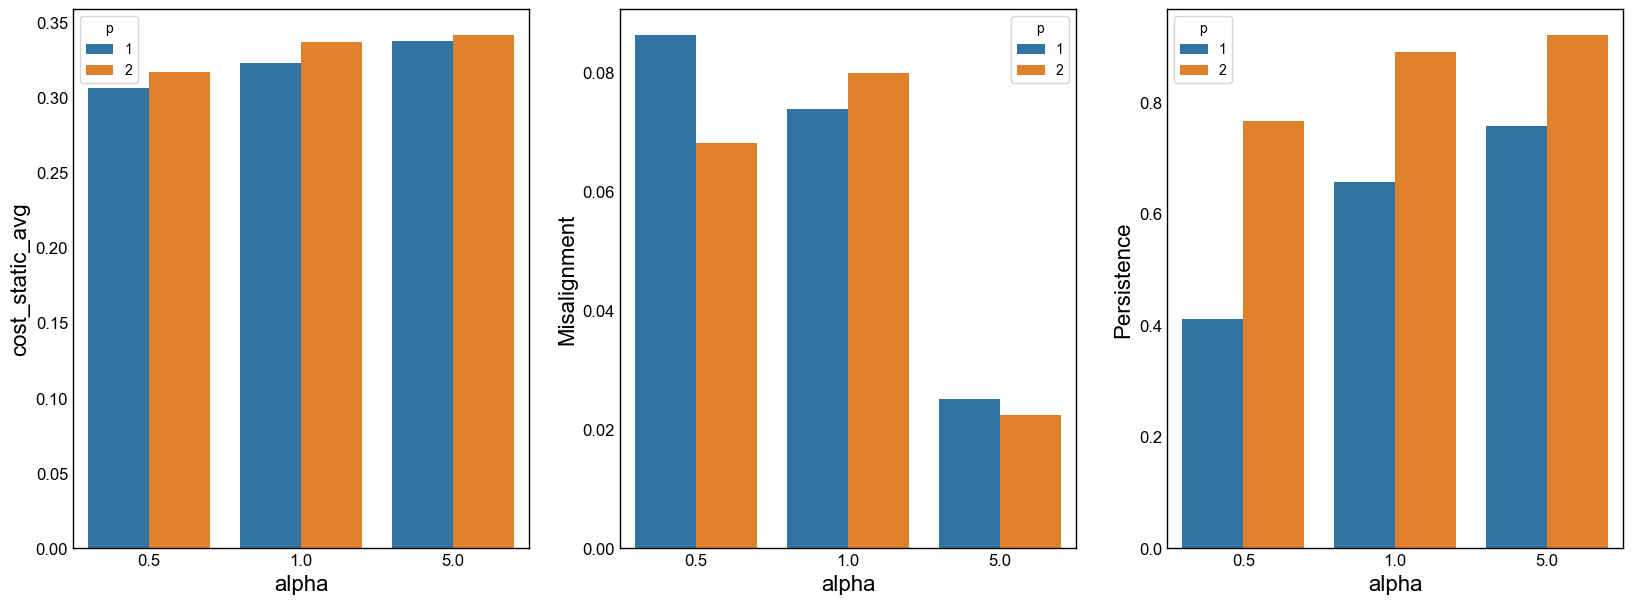

In [34]:
fig, ax = plt.subplots(1,3, figsize = (20,7))

sns.barplot(x = 'alpha', y = 'cost_static_avg', hue = 'p', data = df_res.reset_index(), ax = ax[0])
sns.barplot(x = 'alpha', y = 'Misalignment', hue = 'p', data = df_res.reset_index(), ax = ax[1])
sns.barplot(x = 'alpha', y = 'Persistence', hue = 'p', data = df_res.reset_index(), ax = ax[2])

From this graph, alpha = 5 and p = 2 seem reasonable.

In [35]:
model_MDS.set_params({'alpha': 5, 'p': 2})
Ys_MDS = model_MDS.fit_transform(Ds_norm)

[EvoMDS] Diverging gradient norm at iteration 13
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 19
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 48
[EvoMDS] Adjusting step sizes..


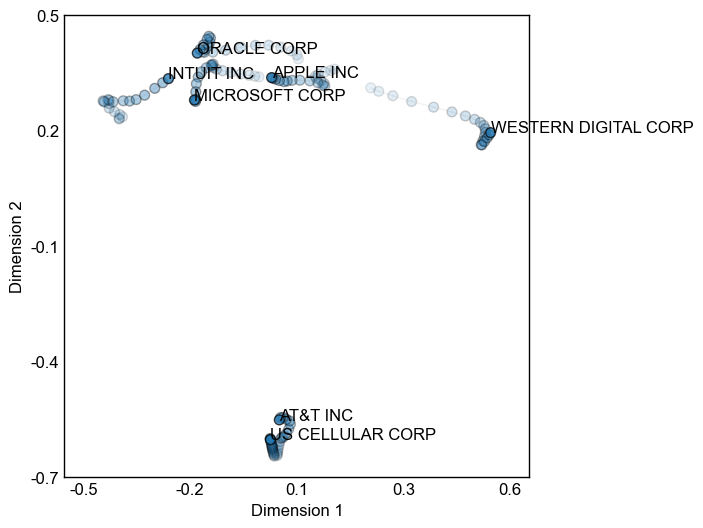

In [36]:
draw_dynamic_map(Ys_MDS, show_arrows = True, label = names)

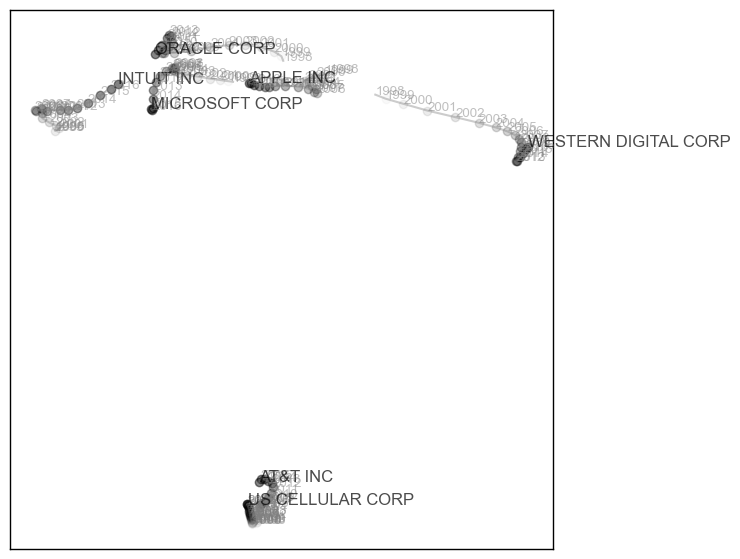

In [37]:
draw_trajectories(Ys_MDS, labels = names, period_labels = years)